In [4]:
import numpy as np
import pandas as pd
import cv2

def visualize_displacement_with_scalebar(displacement, valid_mask, min_val, max_val, title, color_map=cv2.COLORMAP_JET):
    # 归一化到0-255
    disp_norm = np.zeros_like(displacement, dtype=np.float32)
    disp_norm[valid_mask > 0] = displacement[valid_mask > 0]
    disp_norm = np.clip(disp_norm, min_val, max_val)
    disp_norm = ((disp_norm - min_val) / (max_val - min_val) * 255).astype(np.uint8)
    disp_norm[valid_mask == 0] = 0

    # 伪彩色
    color_disp = cv2.applyColorMap(disp_norm, color_map)
    # 黑色背景
    background = np.zeros_like(color_disp)
    color_disp = np.where(valid_mask[..., None] > 0, color_disp, background)

    # 边框设置（黑色）
    top_border = 40
    bottom_border = 70
    left_right_border = 30
    h, w = displacement.shape
    result = cv2.copyMakeBorder(color_disp, top_border, bottom_border, left_right_border, left_right_border,
                                cv2.BORDER_CONSTANT, value=[0,0,0])

    # 标题（白色字）
    cv2.putText(result, title, (left_right_border, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255,255,255), 1, cv2.LINE_AA)

    # 色条
    bar_width = w - 60 if w > 100 else max(30, w-10)
    bar_height = 20
    bar_x = left_right_border + 30
    bar_y = result.shape[0] - bottom_border + 20

    scale_bar = np.zeros((bar_height, bar_width, 3), dtype=np.uint8)
    for x in range(bar_width):
        value = int(x / bar_width * 255)
        color = cv2.applyColorMap(np.array([[value]], dtype=np.uint8), color_map)[0,0]
        scale_bar[:, x, :] = color
    result[bar_y:bar_y+bar_height, bar_x:bar_x+bar_width] = scale_bar

    # 标注最小/最大值（白色字）
    min_text = f"{min_val:.2f}"
    max_text = f"{max_val:.2f}"
    cv2.putText(result, min_text, (bar_x - 5, bar_y + bar_height + 15), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,255,255), 1, cv2.LINE_AA)
    cv2.putText(result, max_text, (bar_x + bar_width - 40, bar_y + bar_height + 15), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,255,255), 1, cv2.LINE_AA)
    cv2.putText(result, "[pixels]", (bar_x + bar_width//2 - 20, bar_y + bar_height + 15), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,255,255), 1, cv2.LINE_AA)

    return result

# 读取csv
df = pd.read_csv('reference.csv')

# 假设 x, y 是像素坐标，u,v 是位移
x = df['x']
y = df['y']
u = df['u']
v = df['v']

# 获取坐标范围作为图像大小
x_min, x_max = int(x.min()), int(x.max())
y_min, y_max = int(y.min()), int(y.max())
img_w, img_h = x_max - x_min + 1, y_max - y_min + 1

# 构造 u,v 的二维数组（与像素图像对应）
umap = np.zeros((img_h, img_w), dtype=np.float32)
vmap = np.zeros((img_h, img_w), dtype=np.float32)
valid_mask = np.zeros((img_h, img_w), dtype=np.uint8)

# 映射到像素
for xi, yi, ui, vi in zip(x, y, u, v):
    py, px = int(yi)-y_min, int(xi)-x_min
    umap[py, px] = ui
    vmap[py, px] = vi
    valid_mask[py, px] = 1

# 可视化 U、V，自动计算色条范围
u_valid = umap[valid_mask > 0]
v_valid = vmap[valid_mask > 0]
u_min, u_max = float(u_valid.min()), float(u_valid.max())
v_min, v_max = float(v_valid.min()), float(v_valid.max())

u_img = visualize_displacement_with_scalebar(umap, valid_mask, u_min, u_max, "U displacement [pixels]")
v_img = visualize_displacement_with_scalebar(vmap, valid_mask, v_min, v_max, "V displacement [pixels]")

cv2.imshow('u colormap', u_img)
cv2.imshow('v colormap', v_img)
cv2.waitKey(0)
cv2.destroyAllWindows()

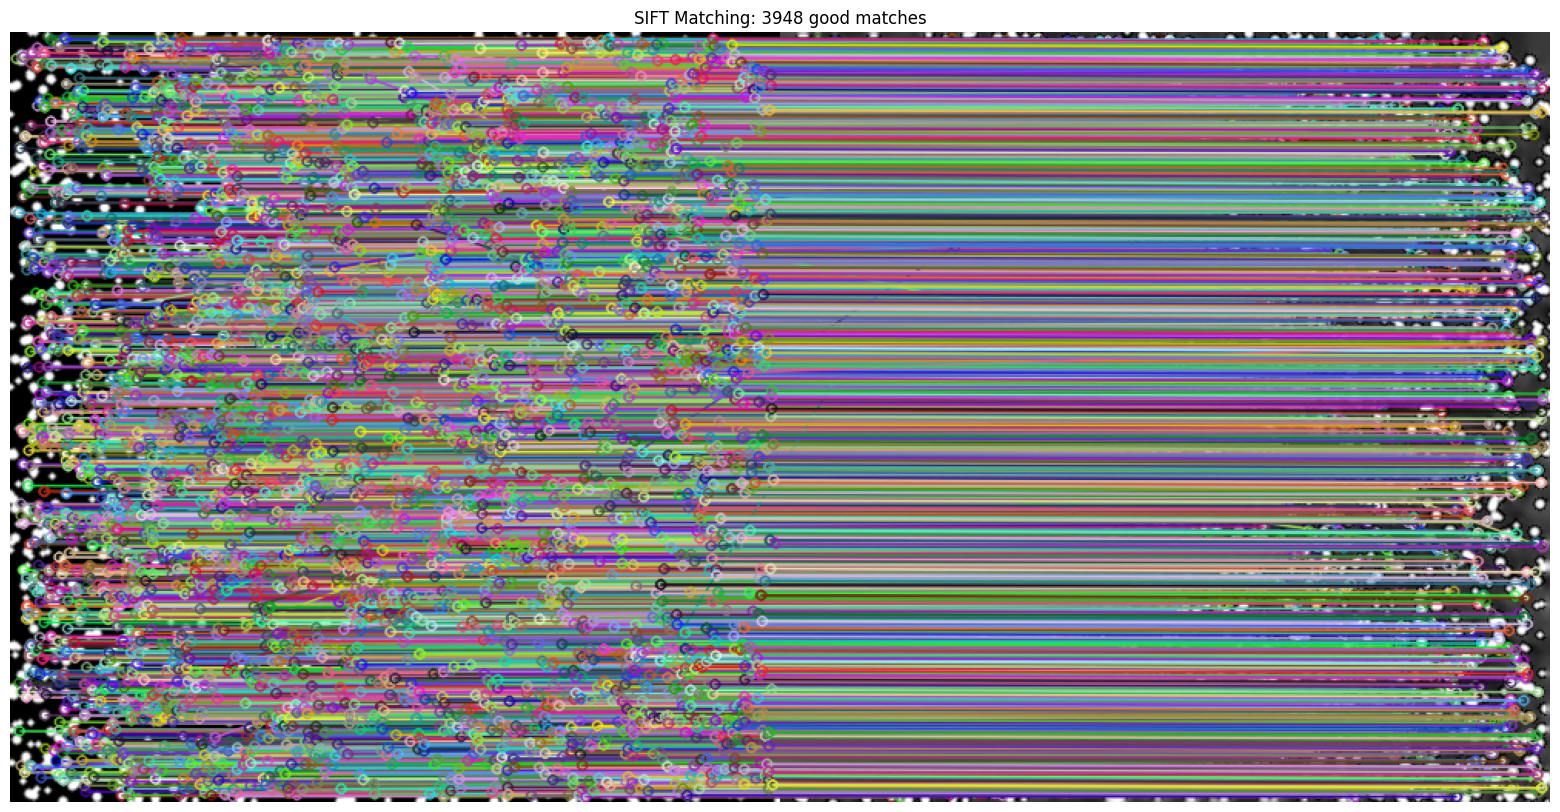

In [1]:

import cv2
import numpy as np
from matplotlib import pyplot as plt

# 读取图片（假设图片已保存为 image1.png 和 image2.png）
img1 = cv2.imread('reference.png', cv2.IMREAD_GRAYSCALE)
img2 = cv2.imread('deformed.png', cv2.IMREAD_GRAYSCALE)

# 初始化SIFT
sift = cv2.SIFT_create()

# 检测关键点和描述符
kp1, des1 = sift.detectAndCompute(img1, None)
kp2, des2 = sift.detectAndCompute(img2, None)

# 用FLANN进行匹配
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
search_params = dict(checks=50)
flann = cv2.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(des1, des2, k=2)

# Lowe's ratio test
good = []
for m, n in matches:
    if m.distance < 0.7 * n.distance:
        good.append(m)

# 可视化匹配结果
img_match = cv2.drawMatches(
    img1, kp1, img2, kp2, good, None,
    flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
)

plt.figure(figsize=(20, 10))
plt.imshow(img_match, cmap='gray')
plt.axis('off')
plt.title(f'SIFT Matching: {len(good)} good matches')
plt.show()